In [26]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from scipy import linalg


## 1. Data information

In [27]:
img_path = "frt00016438_07_su164j_mtr3.img"

dataset = rasterio.open(img_path)
img_data = dataset.read()

# information
profile = dataset.profile
print(profile)
print("Width:", dataset.width)
print("Height:", dataset.height)
print("Count (bands):", dataset.count)
print("CRS:", dataset.crs)
print(f"Tags: {dataset.tags()}")


{'driver': 'ENVI', 'dtype': 'float32', 'nodata': 65535.0, 'width': 736, 'height': 675, 'count': 60, 'crs': CRS.from_wkt('PROJCS["MRO Mars Equirectangular [IAU 2000] [-20.00N; 0.00E]",GEOGCS["GCS_Mars_2000_IAU_IAG_custom_sphere_lat20",DATUM["D_Mars_2000_IAU_IAG_custom_sphere_lat20",SPHEROID["Mars_2000_IAU_IAG_custom_sphere_lat20",3393833.26075839,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",-20],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(18.0, -0.0, 1517858.4,
       -0.0, -18.0, -1373870.9), 'blockxsize': 736, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Width: 736
Height: 675
Count (bands): 60
CRS: PROJCS["MRO Mars Equirectangular [IAU 2000] [-20.00N; 0.00E]",GEOGCS["GCS_Mars_2000_IAU_IAG_custom_sphere_lat20",DATUM["D_Mars_2000_IAU_IAG

The first band shape:  (675, 736)
Minimum:  0.08310713
Maximum:  0.29907113
Mean:  0.19962706


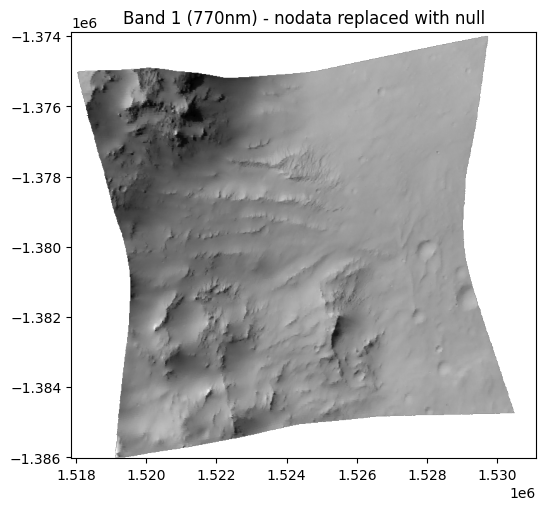

In [28]:
# Read the first band
band1 = dataset.read(1)
band1[band1 == 65535] = np.nan

# information
print("The first band shape: ", band1.shape)
print("Minimum: ", np.nanmin(band1))
print("Maximum: ", np.nanmax(band1))
print("Mean: ", np.nanmean(band1))

# Read pixel image
fig, ax = plt.subplots(figsize=(6, 6))
show(band1, transform=dataset.transform, cmap='gray', ax=ax)
ax.set_title("Band 1 (770nm) - nodata replaced with null")
plt.show()

dataset.close()

## 2. Define the mineral-band mapping table

In [29]:
# Define the mineral-band mapping table
MINERAL_CONFIG = {
    'iron_oxide': {
        'bands': ['BD530_2', 'SH600_2', 'BD640_2', 'BD860_2'],
        'cmap': 'hot'
    },
    'mafic_silicate': {
        'bands': ['OLINDEX3', 'LCPINDEX2', 'HCPINDEX2', 'BDI1000VIS'],
        'cmap': 'viridis'
    },
    'clay_hydrated': {
        'bands': ['BD1900_2', 'BD1900R2', 'BD2100_2', 'BD2210_2'],
        'cmap': 'Blues'
    },
    'sulfate': {
        'bands': ['BD1400', 'BD1500_2', 'BD1750_2', 'SINDEX2'],
        'cmap': 'Oranges'
    },
    'carbonate': {
        'bands': ['BD2500_2', 'CINDEX2', 'BD3000', 'BD3100'],
        'cmap': 'Greens'
    }
}

# Defines the label dictionary for all bands
tags = {
    'Band_1': 'R770',
    'Band_2': 'RBR',
    'Band_3': 'BD530_2',
    'Band_4': 'SH600_2',
    'Band_5': 'SH770',
    'Band_6': 'BD640_2',
    'Band_7': 'BD860_2',
    'Band_8': 'BD920_2',
    'Band_9': 'RPEAK1',
    'Band_10': 'BDI1000VIS',
    'Band_11': 'R440',
    'Band_12': 'IRR1',
    'Band_13': 'BDI1000IR',
    'Band_14': 'OLINDEX3',
    'Band_15': 'R1330',
    'Band_16': 'BD1300',
    'Band_17': 'LCPINDEX2',
    'Band_18': 'HCPINDEX2',
    'Band_19': 'VAR',
    'Band_20': 'ISLOPE1',
    'Band_21': 'BD1400',
    'Band_22': 'BD1435',
    'Band_23': 'BD1500_2',
    'Band_24': 'ICER1_2',
    'Band_25': 'BD1750_2',
    'Band_26': 'BD1900_2',
    'Band_27': 'BD1900R2',
    'Band_28': 'BDI2000',
    'Band_29': 'BD2100_2',
    'Band_30': 'BD2165',
    'Band_31': 'BD2190',
    'Band_32': 'MIN2200',
    'Band_33': 'BD2210_2',
    'Band_34': 'D2200',
    'Band_35': 'BD2230',
    'Band_36': 'BD2250',
    'Band_37': 'MIN2250',
    'Band_38': 'BD2265',
    'Band_39': 'BD2290',
    'Band_40': 'D2300',
    'Band_41': 'BD2355',
    'Band_42': 'SINDEX2',
    'Band_43': 'ICER2_2',
    'Band_44': 'MIN2295_2480',
    'Band_45': 'MIN2345_2537',
    'Band_46': 'BD2500_2',
    'Band_47': 'BD3000',
    'Band_48': 'BD3100',
    'Band_49': 'BD3200',
    'Band_50': 'BD3400_2',
    'Band_51': 'CINDEX2',
    'Band_52': 'BD2600',
    'Band_53': 'IRR2',
    'Band_54': 'IRR3',
    'Band_55': 'R530',
    'Band_56': 'R600',
    'Band_57': 'R1080',
    'Band_58': 'R1506',
    'Band_59': 'R2529',
    'Band_60': 'R3920'
}


## 3. Data processing

In [30]:
# Set the file path
file_path = "frt00016438_07_su164j_mtr3.img"

# Feature shapes:(bands, height, width)
dataset = rasterio.open(file_path)
data = dataset.read()
dataset.close()

# transfer to: (height, width, bands)
data = np.moveaxis(data, 0, -1)
print("data shape（height, width, bands）：", data.shape)


data shape（height, width, bands）： (675, 736, 60)


In [32]:
# Set the target mineral type ('iron_oxide','mafic_silicate','clay_hydrated','sulfate','carbonate')
mineral_type = "clay_hydrated"

try:
    # Generate a list of all band names
    band_names = [tags[f'Band_{i + 1}'] for i in range(data.shape[-1])]
    # Get the band name list corresponding to the target mineral
    target_bands = MINERAL_CONFIG[mineral_type]['bands']
    # Find the index of the target band in the data
    band_indices = [band_names.index(b) for b in target_bands]
    print("Target band name：", target_bands)
    print("Target band index：", band_indices)
except ValueError as e:
    raise ValueError(f"Missing bands: {str(e)}") from None
except KeyError:
    raise KeyError(f"Undefined mineral type: {mineral_type}") from None


Target band name： ['BD1900_2', 'BD1900R2', 'BD2100_2', 'BD2210_2']
Target band index： [25, 26, 28, 32]


In [33]:
# Replace invalid data with value 65535.0 with NaN
data[data == 65535.0] = np.nan

# Replace NaN with the mean of the band
for idx in band_indices:
    band_data = data[..., idx]
    mean_val = np.nanmean(band_data)
    band_data[np.isnan(band_data)] = mean_val


In [34]:
# Extract the target band data (shape: (height, width, 4))
subset_data = data[..., band_indices]
height, width, n_bands = subset_data.shape
print("The shape of the extracted target band data：", subset_data.shape)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data.reshape(-1, n_bands)).reshape(height, width, n_bands)
print("The shape of the data after normalization is: ", scaled_data.shape)


The shape of the extracted target band data： (675, 736, 4)
The shape of the data after normalization is:  (675, 736, 4)


## 4. Dimensionality reduction

In [35]:
# Flatten the data（one pixel per row, one band per column）
flattened = scaled_data.reshape(-1, n_bands)

# PCA
pca_model = PCA(n_components=4)
components = pca_model.fit_transform(flattened)

# Restore to image shape (height, width, 4)
dr_result = components.reshape(height, width, 4)
print("The shape of the data after dimensionality reduction is: ", dr_result.shape)


The shape of the data after dimensionality reduction is:  (675, 736, 4)


## 5. Plot

PCA eigenvectors: 
 [[ 0.63575995  0.59797716 -0.4641281   0.15105519]
 [-0.19208223 -0.30583036 -0.37998727  0.85157615]
 [ 0.14767222  0.32702762  0.7869727   0.5019161 ]
 [ 0.7328756  -0.6647887   0.14446008 -0.00898006]]


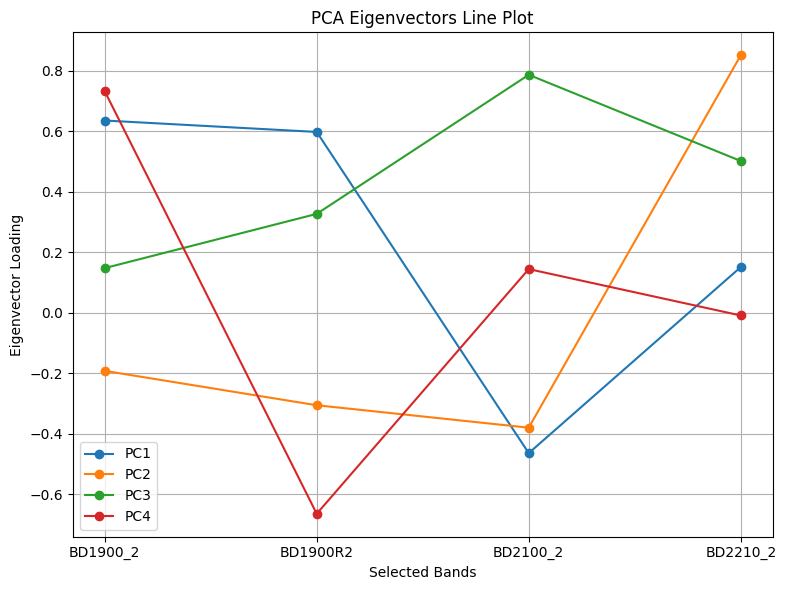

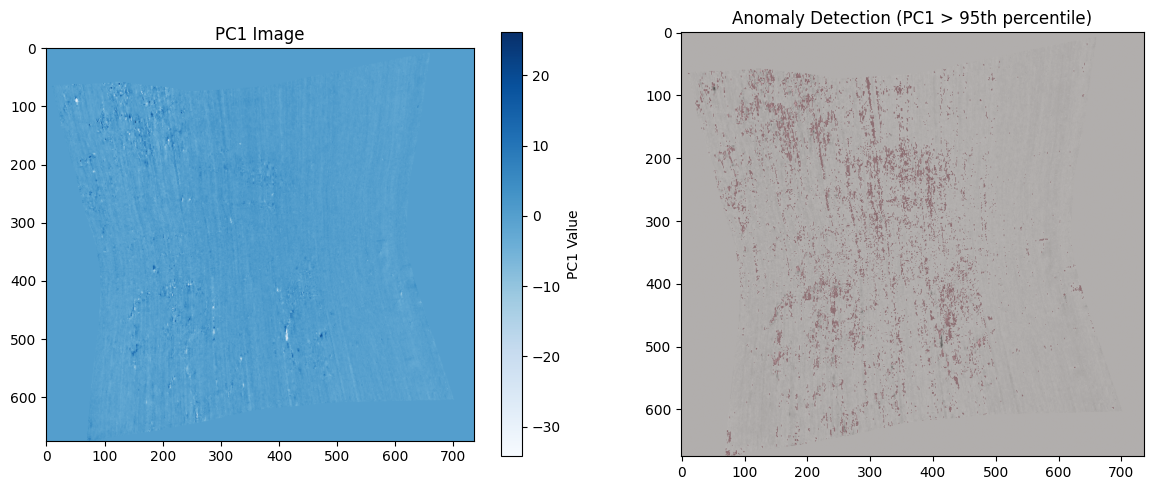

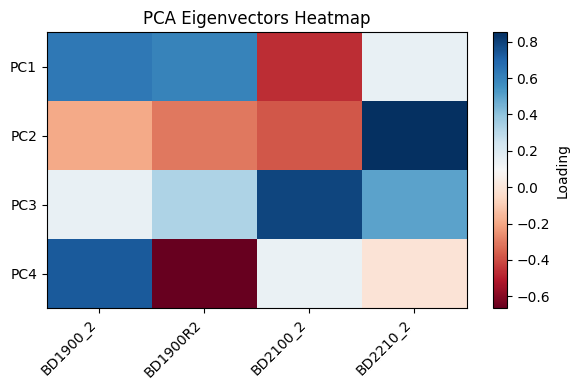

In [36]:
# Get the eigenvectors
eigenvectors = pca_model.components_
print("PCA eigenvectors: \n", eigenvectors)

# PCA loadings line plot
plt.figure(figsize=(8, 6))
for pc_idx in range(eigenvectors.shape[0]):
    plt.plot(range(n_bands),
             eigenvectors[pc_idx, :],
             marker='o',
             label=f'PC{pc_idx+1}')
plt.xticks(range(n_bands), target_bands, rotation=0)
plt.xlabel("Selected Bands")
plt.ylabel("Eigenvector Loading")
plt.title("PCA Eigenvectors Line Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# PC1 anomaly detection graph
# Take the first principal component as an example
main_component = dr_result[..., 0]
threshold = np.percentile(main_component, 95)
anomaly_mask = main_component > threshold

plt.figure(figsize=(12, 5))
# Left: Displays the PC1 image
plt.subplot(1, 2, 1)
plt.imshow(main_component, cmap=MINERAL_CONFIG[mineral_type]['cmap'])
plt.colorbar(label='PC1 Value')
plt.title("PC1 Image")
# Right: Superimposed abnormal area
plt.subplot(1, 2, 2)
plt.imshow(main_component, cmap='gray')
plt.imshow(anomaly_mask, cmap='Reds', alpha=0.3)
plt.title("Anomaly Detection (PC1 > 95th percentile)")
plt.tight_layout()
plt.show()

# PCA heatmap
plt.figure(figsize=(6, 4))
plt.imshow(eigenvectors, cmap='RdBu', aspect='auto')
plt.colorbar(label='Loading')
plt.xticks(range(len(target_bands)), target_bands, rotation=45, ha='right')
plt.yticks(range(eigenvectors.shape[0]), [f'PC{i+1}' for i in range(eigenvectors.shape[0])])
plt.title("PCA Eigenvectors Heatmap")
plt.tight_layout()
plt.show()